# Task 2: Develop Recurrent Neural Network(s) For Sequence-to-Sequence Classification

**Note**: I have run the code on a local machine GPU due to limited resources provided by the Google Colab platform. Therefore, you might get different results than mine even though the reproducibility measures applied below. That's just how GPUs work...

To begin with, we provide a walkthrough on how to replicate the task on Google Colab. First, we need to extract the soybean dataset from the ZIP file (download from MyAberdeen). Therefore, we first mount our drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Then, we upload the dataset ZIP file to our google drive and execute:

    !unzip your_drive_path_to_data.zip -d './data/' 

where *your_drive_path_to_data.zip* (*CS5062_AssessmentII_Dataset.zip* in our case) should be replaced by the actual path of the dataset ZIP file on your drive.

Alternatively, we can place the dataset zip file in the current directory and execute (tested in colab):

    !unzip 'CS5062_AssessmentII_Dataset.zip' -d './data/' 

Below is the location of the dataset ZIP file on my Google Drive. This will differ in your case, so please adjust as needed.

In [1]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Assessment_2/CS5062_AssessmentII_Dataset.zip' -d './data/'


### Setting a Fixed Seed Value for the Random Number Generator and Importing Libraries

Randomness is in the nature of neural networks which employ it to ensure a better performance on a specific task. However, we need to seed the random number generator to get reproducible results when training and comparing models. 

*Note that randomness might still occur such as the random initialisation of model weights when constructing a model. Thus, the output results might differ each time the script is run (generally on GPU). We put great deal of effort into making the script results as repeatable as possible.*

- First, we install the new Tensorflow determinism package allowing reproducibility on GPUs.


- Then, we seed the random number generators and import the required packages for model development and visualisation (i.e tensorflow, keras, matplotlib).

In [ ]:
# Install the determinism package of Tensorflow
# If the program throws attribute error the simply
# uninstall the Keras package (since tensorflow already
# provides it)
!pip install tensorflow-determinism

In [1]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# Import the Keras backend used for freeing the global state
# to avoid clutter
from tensorflow.keras import backend as K

## Subtask a. Data Preparation and Import

### Importing the Data

We adopt the `pandas` Python package to read the train and test comma-separated values (csv) dataset files into 2 `DataFrame` structures. Specifically, we use the `read_csv` functions of the package to carry out the task.

In [2]:
# Import the crucial Pandas and Matplotlib packages 
# used for data preparation and visualisation respectively
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 'Read' the train and test data into Pandas data frames
train_df, test_df = pd.read_csv('data/Train.csv'), pd.read_csv('data/Test.csv')

#### Describing the Data

We employ the `DataFrame.describe()` method of the `pandas` library to display some basic statistical details like percentile, mean, std etc. of our data frame. We also show the shapes of the train and test datasets.

In [3]:
# Print the training dataset shape and describe the set
print(f'Training data shape: {train_df.shape}\n')
train_df.describe()

Training data shape: (107085, 3)



,Trip,VehicleSpeed_km_h_,Battery_Status
count,107085.000000,107085.000000,107085.000000
mean,2398.752832,34.640675,0.264388
std,509.159153,22.455519,0.441009
min,1567.000000,0.000000,0.000000
25%,1949.000000,15.589999,0.000000
50%,2384.000000,36.270000,0.000000
75%,2902.000000,52.529999,1.000000
max,3263.000000,103.430000,1.000000


In [4]:
# Print the test dataset shape and describe the set
print(f'Test data shape: {test_df.shape}\n')
test_df.describe()

Test data shape: (60172, 3)



,Trip,VehicleSpeed_km_h_,Battery_Status
count,60172.000000,60172.000000,60172.000000
mean,2449.359320,34.255137,0.257346
std,447.700622,22.876331,0.437175
min,1558.000000,0.000000,0.000000
25%,2105.000000,13.960000,0.000000
50%,2533.000000,36.369999,0.000000
75%,2806.000000,53.590000,1.000000
max,3271.000000,84.650002,1.000000


We notice that the dataset consists only of numeric values. There are 107,058 records of train and 60,172 records of test data, each with 2 features &mdash; `Trip` and `VehicleSpeed_km_h_` &mdash; and a target variable `Battery_Status`. Moreover, it is worth noting that the feature value ranges are different (quantities in the 10s and 1000s thus not scaled) for each feature. Hence, we will need to perform some data scaling on the provided data which is detailed in the sections below. The maximum, minimum, mean values etc. are all observable in the data frame shown above.

### Preparing the Data

In the task requirements it is specifically stated that:

- **"For the sake of reducing time for training and running a model, only speed is used to predict the battery status."**

Therefore, we need to reduce the dimensionality of the train and test data to 1 feature (`VehicleSpeed_km_h_` column) by removing the 'Trip' feature since we only care about how EV speed affects its battery status. We perform this by using the `drop()` function of the `pandas.DataFrame` package as shown in the code below:

In [5]:
# Drop the 'Trip' column from both training and test data frames
train_df_reduced = train_df.drop(["Trip"], axis=1)
test_df_reduced = test_df.drop(["Trip"], axis=1)


#### Handling Missing Values

First, we need to check if there are any missing (`NaN`) values our dataset. This can be evaluated via the `isnull()` or `isna()` functions of the `pandas.DataFrame` structure as shown below.


In [6]:
# Check for null values
train_df_reduced.isnull().values.any(),  test_df_reduced.isnull().values.any()

(False, False)

Apparently, there are no missing values in our train and test sets. This is a good thing because e if a dataset is full of `NaN` (junk) values, then the trained model will surely show a poor performance. So taking care of such missing values is indeed an important preprocessing step which is not required in our scenario.

#### Visualisation

Next, we plot some figures to visualise our data.

First of all, let us see some data histograms for both the training and test datasets. This will show us the actual data distributions over the `VehicleSpeed_km_h_` feature and the `Battery_Status` target variable.

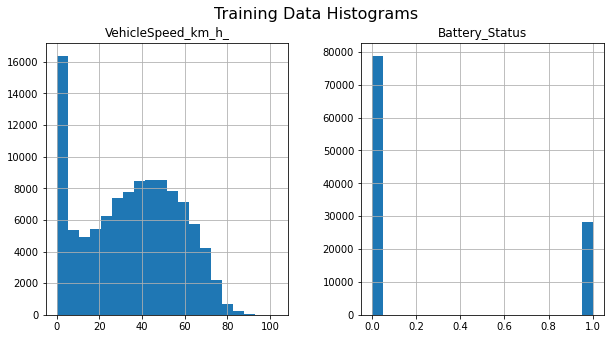

In [7]:
# Plot training data histograms
train_df_reduced.hist(bins=20, figsize=(10,5))
plt.suptitle("Training Data Histograms", fontsize=16)
plt.show()

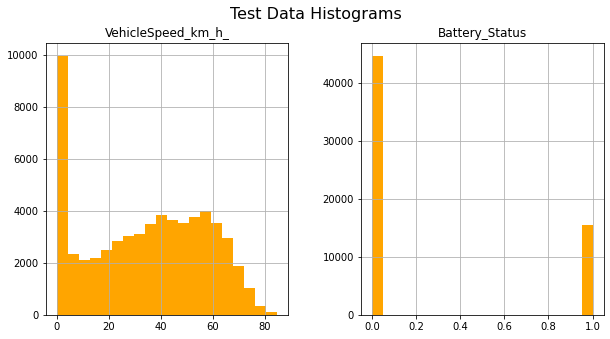

In [8]:
# Plot test data histograms
test_df_reduced.hist(bins=20, figsize=(10,5), color='orange')
plt.suptitle("Test Data Histograms", fontsize=16)
plt.show()

The above figures depict that the majority of the `Battery_Status` target variable values are 0 while the rest are 1's. Moreover, the input feature `VehicleSpeed_km_h` comprise values that follow a normal (Gaussian) distribution. Therefore, a suitable scaling method in our case would be standardisation.

In [9]:
# Print the 0's to 1's ratio of the training data
all_zeroes_train = train_df[train_df['Battery_Status']==0]['Battery_Status'].count()
all_ones_train = train_df[train_df['Battery_Status']==1]['Battery_Status'].count()
print(f'Train data zeroes:ones ratio: {(all_zeroes_train/all_ones_train)}\n')

# Print the 0's to 1's ratio of the test data
all_zeroes_test = test_df[test_df['Battery_Status']==0]['Battery_Status'].count()
all_ones_test = test_df[test_df['Battery_Status']==1]['Battery_Status'].count()
print(f'Test data zeroes:ones ratio: {(all_zeroes_test/all_ones_test)}')

Train data zeroes:ones ratio: 2.7823184515399833

Test data zeroes:ones ratio: 2.885824991927672


Particularly, we have $\approx 2.7823$ and $\approx 2.8858$ or almost 3 times more 0's than 1's in the train and test sets.

#### Data Types

In [10]:
# Print the both dataset data types of each feature
# together with the memory usage of the data
print('Train Data\n')
train_df_reduced.info()
print('\n' + '-'*50 + '\nTest Data\n')
test_df_reduced.info()

Train Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107085 entries, 0 to 107084
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   VehicleSpeed_km_h_  107085 non-null  float64
 1   Battery_Status      107085 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.6 MB

--------------------------------------------------
Test Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60172 entries, 0 to 60171
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   VehicleSpeed_km_h_  60172 non-null  float64
 1   Battery_Status      60172 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 940.3 KB


Above we can see that the train and test datasets contain 2 diferent data types `int64` and `float64`. Using 64-bit data consumes great deal of memory and in our case the usage of such data type is inefficient since we are not looking for such a high level of result precision. Hence, we can convert the data type of the data frames to to 32-bit (using `int32` and `float32`) to save some memory and boost the algorithm speed.

In [11]:
# Convert both dataset values to 32-bit to save memory usage and boost runtime
train_df_32 = train_df_reduced.astype({"VehicleSpeed_km_h_": 'float32', \
                               "Battery_Status": 'int32'})
test_df_32 = test_df_reduced.astype({"VehicleSpeed_km_h_": 'float32', \
                             "Battery_Status": 'int32'})

#### Separating Features and Labels (Targets)

For this we are going to make use of the `DataFrame.iloc[rows, columns]` method offered by the pandas library. 

In [12]:
# Divide the single feature from the target variable
X_train, y_train = train_df_32.iloc[:,:-1], train_df_32.iloc[:,-1]
X_test, y_test = test_df_32.iloc[:,:-1], test_df_32.iloc[:,-1]

#### Feature Scaling

In general, unscaled data can cause a network's learning and convergence to be slowed down and in some cases even prevent it from learning the problem sufficiently.

We employ standardisation for feature scaling since is not bounded to a certain range making it more robust to outliers. Thus, it is often prefered over the min-max normalisation. 


Also, this technique centers the data around the mean (becomes 0 of the new distribution) with a standard deviation of 1. It is useful for the optimization algorithms, such as gradient descent, that are used within machine-learning algorithms that weight inputs (e.g., regression and neural networks).

In [13]:
# Import the StandardScaler class
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance used in standardising our data
sc = StandardScaler()

# Fit only to the train data to avoid data leakage from the test set.
# Then we transform both the train and test sets.
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### Input Data Reshaping and Coverting Labels

Below, we define the input shape or the data format so that it is handled properly by our Recurrent Neural Network (`RNN`) models. We proceed as follows:

1. The input to every RNN layer must be 3D (samples $\times$ time steps $\times$ features). In other words, when fitting the model and making predictions, the input layer expects a 3D array of data, even if a specific dimension contains a single value, e.g., one sample. 

    - `RNNs` assume that there are one or more samples at the input layer. 
    
    - Subsequently, `RNNs` demand the specification of the number of time steps and features which can be achieved via the `input_shape` argument of the layer. This argument takes the 2-tuple (time steps $\times$ features). We omit the specifying the number of samples since this is determined by the batch size during model fitting.
    - In our case, the `input_shape=(1,1)` because we want to feed 1 point of observation in the samples considering 1 feature at a time (`VehicleSpeed_km_h_`) into the `RNNs`.


2. Next, we reshape our input training and test data (the feature vectors) using the already defined input shape. This way we ensure that it is fed in the correct format into the `RNN`. For the purpose, we adopt the Pandas `reshape()` function.


3. Finally, we convert the training and test labels to binary matrix representations. That is, the 0's (discharging) and 1's (charging) classes are now converted to the `[1 0]` and `[0 1]` binary matrices respectively.

In [14]:
# Define the input shape (batch_size, timesteps, data_dim)
# Sample - a batch is comprised of one or more samples (sequences).
# Time Step - a point of observation in the samples.
# Feature - an observation at a time step.
INPUT_SHAPE = 1, 1 

# Reshape the train and test input data
X_train_rs = X_train_scaled.reshape(-1, *INPUT_SHAPE)
X_test_rs = X_test_scaled.reshape(-1, *INPUT_SHAPE)

# Specify the number of classes as a constant
# which is reused later
NUM_CLASSES = 2

# Convert our class vector (integers) to binary class matrix.
y_train_bm = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_bm = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# Print the changes
print(f'New input data shapes: {y_train_bm.shape, y_test_bm.shape}')
print(f'Default labels: {y_train[71]}, {y_train[72]}')
print(f'Binary matrix representations: {y_train_bm[71]}, {y_train_bm[72]}')

New input data shapes: ((107085, 2), (60172, 2))
Default labels: 0, 1
Binary matrix representations: [1. 0.], [0. 1.]


In [15]:
# Install the Tensorflow addons module which is 
# used for employing additional binary classification 
# metrics such as F1 score, precision, recall, etc
# !pip install tensorflow-addons[tensorflow]

In [16]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Flatten,\
Dropout, BatchNormalization

USE RELU FOR HIDDEN AND SIGMOID ON OUTPUT

### Developing our Baseline RNN Models

In this section we go over our simple `RNN` and `LSTM` baseline models. These will serve as the foundational models for further tuning and improvement. By adopting them, we set a minimum reference model performances for later comparison. Both models are inspirated by <a href="https://www.tensorflow.org/guide/keras/rnn">Tensorflow</a>.

#### The Simple RNN Architecture

In the field of AI, Recurrent Neural Networks (`RNNs`) are used for modelling data sequences, such as time series or natural language. An `RNN` layer iterates over the time steps of a sequence using a loop, while maintaining an internal state that provides information about the time steps it has observed so far.

- Disadvantage &ndash; `RNNs` are prone to the so called vanishing gradient problem. This is caused by the large number of steps being processed. That is, if the gradient gets smaller and smaller at each step of the backpropagation, this causes their exponential shrink and eventually vanish without updating some of the weights. Thus, that would mean that the model would stop learning.


We adopt the Keras `Sequential` API when constructing our simple `RNN`. The `RNN` structure is defined below:


- `SimpleRNN(128)` &ndash; we define the single `RNN` layer with 128 units


- `BatchNormalization()` &ndash; normalisation layer that maintains the mean output close to 0 and the output standard deviation close to 1.


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate to decrease overfitting


- `Dense(10)` &ndash; a fully-connected layer with 10 outputs (units)


- `BatchNormalization()` &ndash; normalisation layer


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate to decrease overfitting


- `Dense(NUM_CLASSES)` &ndash; final fully-connected layer with `NUM_CLASSES=2` outputs since we are dealing with binary classification problem

<center>
    <br>
    <figure>
        <img src="https://drive.google.com/uc?id=1W9nqJYXLLkY7_yGfQivz1drImvIQlOzX" width="350">
        <br>
        <figcaption style="text-align:center"><b>Fig. 1.</b> Baseline simple RNN architecture.</figcaption>
    </figure>
    <br>
</center>


    Considering `CNNs`, it is recommended to begin with smaller filter sizes for better local information capturing. That is, to enable the model to detect low-level features used in forming complex shapes later on. As we go deeper we gradually increase the filter size which reduces the resulting feature space to reflect higher-level information. Moreover, deepening and narrowing the feature space allows the input to be fed into a `Dense` layer. 

- Activation function &ndash; We adopt the `ReLU` activation function to achieve nonlinearity. It is preferred over `tanh` and `sigmoid` activation functions due to its trivial implementation (requires only a `max()` function), representational sparsity (outputs a true zero value), linear function characteristics (easier to optimise) and enables proper deep neural network training.


- Batch normalisation &ndash; intermediate layers are capable of amending the already normalised input before it gets to the deeper layers of the neural network. This might cause an internal co-variate shift that can influence the model learning. A solution to this problem is adding the `BatchNormalization` layer which standardises (centers the mean and scales the variance) the input passed to the inner layers. This layer is generally placed after the activation function output but before the `Dropout` layer (if any). The <a href="https://arxiv.org/abs/1502.03167">original paper</a> that introduces the technique suggests otherwise. Nevertheless, there are reported <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">practical experiments</a> suggesting that the application of the `BatchNormalization` layer after the activation function yields better results. This seems rather reasonable since feeding the batch-normalised output to an activation layer would lead to its alteration and would nullify the conducted normalisation. Hence, we put the `BatchNormalization` layer after the activation function in our `SimpleRNN` and `LSTM` networks.

In [22]:
def simple_rnn_model():
    """Construct and return the simple RNN model architecture
    """
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))

#     model.summary()
    return model

#### The LSTM Architecture

    The `MLP` architecture we develop vertically stacks  2 LSTM layers together 
    SAY ABOUT ADVANTAGE OVER RNN

    RNN width is defined by (1) # of input channels; (2) # of cell's filters (output channels/units). As with CNN, each RNN filter is an independent feature extractor: more is suited for higher-complexity information, including but not limited to: dimensionality, modality, noise, frequency.
    RNN depth is defined by (1) # of stacked layers; (2) # of timesteps. Specifics will vary by architecture, but from information standpoint, unlike CNNs, RNNs are dense: every timestep influences the ultimate output of a layer, hence the ultimate output of the next layer - so it again isn't as simple as "more nonlinearity"; stacked RNNs exploit both spatial and temporal information.



    In case of a simple feedforward net we stack layers to create a hierarchical feature representation of the input data to then use for some machine learning task. The same applies for stacked LSTM's. If the input is already the result from an LSTM layer (or a feedforward layer) then the current LSTM can create a more complex feature representation of the current input. 

    As discussed before, the Keras Sequential API is used for creating the model. 

    Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

    In general, width extracts more features, whereas depth extracts richer features - but if there aren't many features to extract from given data, width should be lessened - and the "simpler" the data/problem, the less layers are suitable.


- `LSTM(128)` &ndash; the first `LSTM` layer with 128 units


- `BatchNormalization()` &ndash; normalisation layer that maintains the mean output close to 0 and the output standard deviation close to 1.


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate to decrease overfitting


- `LSTM(64)` &ndash; a second `LSTM` layer with 64 units


- `BatchNormalization()` &ndash; normalisation layer


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate to decrease overfitting


- `Dense(10)` &ndash; a fully-connected layer with 10 outputs (units)


- `BatchNormalization()` &ndash; normalisation layer


- `Dropout(0.25)` &ndash; a dropout layer with 25% drop rate to decrease overfitting


- `Dense(NUM_CLASSES)` &ndash; final fully-connected layer with `NUM_CLASSES=2` outputs since we are dealing with binary classification problem


<center>
<br>
<figure>
<img src="https://drive.google.com/uc?id=1JyzQ-4IsQ5mT6C-lZwXCYo84OGry5jbp" width="350">
<br>
<figcaption style="text-align:center"><b>Fig. 2.</b> Baseline simple RNN architecture.</figcaption>
</figure>
<br>
</center>

    The final `Dense` layer has 2 output neuron and activates linearly (no function specified). Using the linear function allows us to generate a real-valued or numeric prediction, which is exactly what we need. That is, we do not want to change in any way our prediction output which non-linear activation functions in the last layer might cause.

     we consider greater number of features before converging to the actual prediction.

    We use `ReLU` based activation because it is one of the standard activation functions used nowadays (as detailed above).

    Next, we define the MLP in code:

RELU Found much success in computer vision applications

In [23]:
def lstm_model():
    """Construct and return the LSTM model architecture
    """
    model = Sequential()
    model.add(LSTM(128, input_shape=(1,1), activation='relu', return_sequences=True)) # return_sequence=True
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(LSTM(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(NUM_CLASSES, activation='sigmoid'))
#     model.summary()
    return model

### Defining the Baseline Model Configuration

- **Batch size** &ndash; The batch size is a hyperparameter used for spicifying the amount of samples that will be sent across the network. As a kickoff, we use a batch size of 32 samples which is stated to be a good default value in the <a href="https://arxiv.org/abs/1206.5533">following paper</a>. In general, smaller batch sizes are mainly used because they offer regularisation and improved generalisation.


- **Epochs** &ndash; this is the number of passes of the whole training dataset the algorithm is expected to complete. We use 10 epochs to quickly evaluate our baseline models. We will adjust this hyperparameter later on when we conduct the model hyperparameter optimisation procedure.


- **Validation split** &ndash; we adopt 25% of the training data, or 20% of the whole dataset, for validation training of our baseline models.


- **Optimiser** &ndash; we pick the `Adam` algorithm since it is a popular deep learning method that quickly produces good results. This optimiser combines the advantages of the AdaGrad and RMSProp algorithms into a technique that can tackle sparse gradients on noisy tasks. We use the default `learning_rate=0.001` value of the `Adam` algorithm for our baseline model evaluations which is to be tuned at a later point.


- **Loss function** &ndash; we use the Mean Squared Error (`MSE`) loss function which is the default for regression problems. Furthermore, we choose the `RMSE` metric to report the performance of our models. 


Finally, we wish to see as much output as possible, thus configure the training process to be verbose.
Cross-entropy is the default loss function to use for binary classification problems.

It is intended for use with binary classification where the target values are in the set {0, 1}.

Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for predicting class 1. The score is minimized and a perfect cross-entropy value is 0.

In [ ]:
from tensorflow.keras.optimizers import Adam
LOSS = BinaryCrossentropy()
OPTIMISER = Adam()
METRICS = ['accuracy', F1Score(num_classes=NO_CLASSES, average = 'macro')]

In [186]:
model = simple_rnn_model()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, 128)               16640     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 10)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
dropout_45 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)               

In [187]:
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.losses import BinaryCrossentropy      

# https://www.tensorflow.org/text/tutorials/text_classification_rnn

# from_logits=True when output values are not [0, 1]
model.compile(loss=LOSS,
              optimizer=OPTIMISER,
              metrics=METRICS)

es_callback = tf.keras.callbacks.\
    EarlyStopping(monitor='f1_score', patience=3)

model.fit(X_train_rs, y_train_new, epochs=10, 
                        validation_split=.25,
                        batch_size=32, verbose=1,
                        callbacks=[es_callback])


Epoch 1/10
 293/2510 [==>...........................] - ETA: 40s - loss: 0.8208 - accuracy: 0.5234 - f1_score: 0.4803

KeyboardInterrupt: 

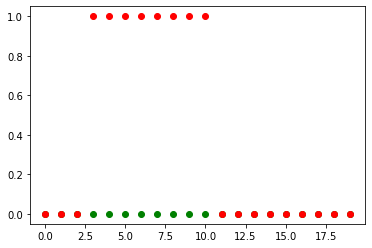

In [195]:
plt.scatter(range(20),y_train[:20], c='g')
plt.scatter(range(20),y_test[:20], c='r')

In [110]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'pyplot' is not defined

https://www.pluralsight.com/guides/deep-learning-model-perform-binary-classification

- The above code compiles the network. It uses Adam, a momentum-based optimizer. The loss function used is binary_crossentropy. 


- For binary classification problems that give output in the form of probability, binary_crossentropy is usually the optimizer of choice. 


- mean_squared_error may also be used instead of binary_crossentropy as well. Metrics used is accuracy. 


- The model is trained for 50 epochs with a batch size of 1. Finally, the trained model was evaluated for the test set to check the accuracy.


If your problem is a binary classification problem, then the output will be class values 0 and 1. This is best modeled with a sigmoid activation function on the output layer. 

FINAL

Did not consider Keras Tuner + Cross-validation due to time constraints but left for future work. It would be painfully slow to train a single RNN model.

try different scaling